In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

# sorting data

In [2]:
#sorting data
data = pd.DataFrame(columns = ['image_path','label'])

#input the path
labels = {'/Users/shurui/data/tom' : 'tom',
          '/Users/shurui/data/jerry' : 'jerry',
          '/Users/shurui/data/both' : 'both',
          '/Users/shurui/data/none' : 'none',
           }   

for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)

#store in a csv file.
data.to_csv('image_dataset.csv', index=False)

df = pd.read_csv("/Users/shurui/image_dataset.csv")

df

,image_path,label
0,/Users/shurui/data/tom/frame4966.jpg,tom
1,/Users/shurui/data/tom/frame583.jpg,tom
2,/Users/shurui/data/tom/frame4972.jpg,tom
3,/Users/shurui/data/tom/frame1822.jpg,tom
4,/Users/shurui/data/tom/frame2481.jpg,tom
...,...,...
5473,/Users/shurui/data/none/frame2498.jpg,none
5474,/Users/shurui/data/none/frame1185.jpg,none
5475,/Users/shurui/data/none/frame3962.jpg,none
5476,/Users/shurui/data/none/frame3976.jpg,none


In [3]:
#Grouping data， train_set ： validation_set = 8 ： 2
train_dir, validation_dir = train_test_split(df, test_size=0.2, random_state=42)

# data preprocessing

In [4]:
#data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #Data Augmentation
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   fill_mode='nearest') #Data Augmentation
test_datagen = ImageDataGenerator (rescale=1./255)

#two generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_dir,
    x_col = "image_path",
    y_col = "label",
    target_size = (224, 224),
    batch_size = 32,
    shuffle=True,
    class_mode = 'categorical')
    
validation_generator = test_datagen.flow_from_dataframe(
    dataframe = validation_dir,
    x_col = "image_path",
    y_col = "label",
    target_size = (224, 224),
    batch_size = 32,
    shuffle=False,
    class_mode = 'categorical')

Found 4382 validated image filenames belonging to 4 classes.
Found 1096 validated image filenames belonging to 4 classes.


# build the model

In [5]:
#build the models
base_model = tf.keras.applications.ResNet50(include_top=False, 
                                            weights='imagenet', 
                                            input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, 
                          activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(4, 
                                    activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, 
                              outputs=predictions)

# loss function
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=1e-4), 
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', 
                                                monitor='val_accuracy', 
                                                save_best_only=True, 
                                                mode='max', verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                 patience=20, 
                                                 mode='max', 
                                                 verbose=1)

# Train

In [6]:
# train
history = model.fit(train_generator,
                    epochs=10, #10times
                    validation_data=validation_generator, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/10


2023-03-12 16:51:50.424470: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


137/137 [==============================] - ETA: 0s - loss: 1.0015 - accuracy: 0.6333
Epoch 1: val_accuracy improved from -inf to 0.27281, saving model to model.h5
137/137 [==============================] - 458s 3s/step - loss: 1.0015 - accuracy: 0.6333 - val_loss: 2.6619 - val_accuracy: 0.2728
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.8122
Epoch 2: val_accuracy did not improve from 0.27281
137/137 [==============================] - 453s 3s/step - loss: 0.5462 - accuracy: 0.8122 - val_loss: 2.6147 - val_accuracy: 0.2728
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8590
Epoch 3: val_accuracy did not improve from 0.27281
137/137 [==============================] - 749s 5s/step - loss: 0.4274 - accuracy: 0.8590 - val_loss: 2.9453 - val_accuracy: 0.2728
Epoch 4/10
137/137 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8788
Epoch 4: val_accuracy did not improve from 0.27281


In [7]:
#evaluation
num_samples = validation_dir.shape[0]
num_samples

1096

In [8]:
score = model.evaluate(validation_generator,
                       steps=num_samples//32+1,
                       )

35/35 [==============================] - 63s 2s/step - loss: 0.2340 - accuracy: 0.9261


# Accuracy and Loss by graph

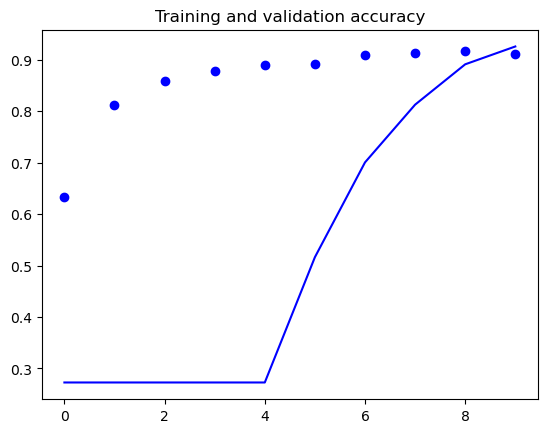

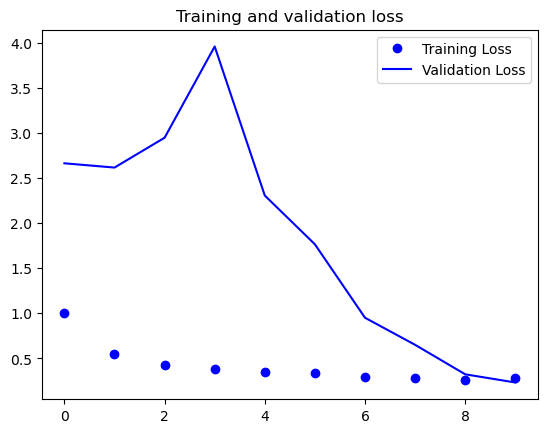

In [9]:
#figure the model by graph
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs , acc , 'bo' , label = 'Trainging accuracy')
plt.plot(epochs , val_acc , 'b' , label = 'Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs , loss , 'bo' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'b' , label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Save the model

In [10]:
# Save the model
model.save('my_model.h5')

# Prediction

In [28]:
import cv2
import numpy as np
from keras.models import load_model
from IPython.display import display, Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#define a function to predict
def predict_image_class(model, image_path):
    # Load image
    img_array = cv2.imread(image_path) #to two-dimension array
    if img_array is None:
        print('Invalid image path:', image_path)
        return None
    
    # Preprocess image
    img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0  #normalization
    img = np.expand_dims(img, axis=0)
    #print(img)  #print the array
    # Make prediction
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    
    # Get class name
    class_names = ['both', 'jerry', 'none', 'tom']
    predicted_class_name = class_names[predicted_class_index]
    
    # Display image
    image = Image(filename=image_path)
    display(image)
    
    # Display predicted class
    print('Predicted class:', predicted_class_name)
    
    return img_array, predicted_class_name


1/1 [==============================] - 0s 363ms/step


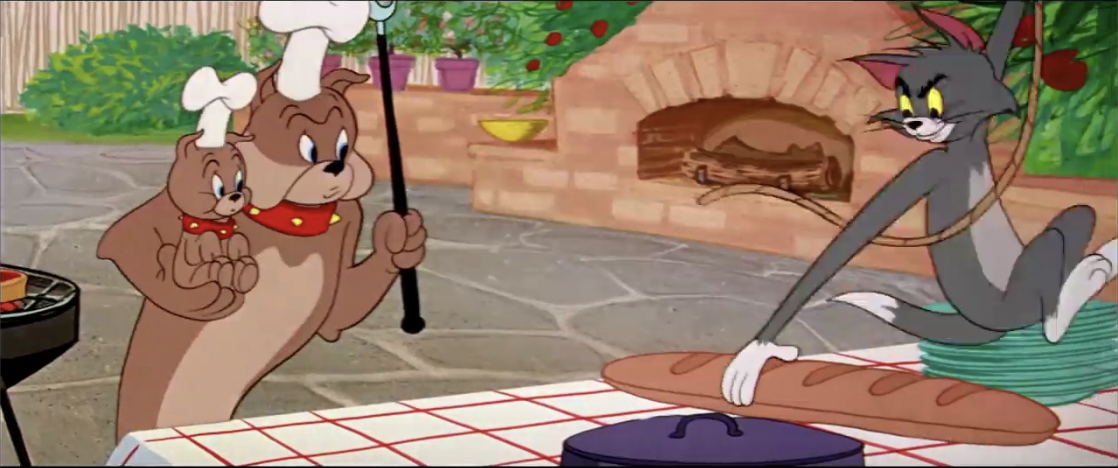

Predicted class: tom
1/1 [==============================] - 0s 72ms/step


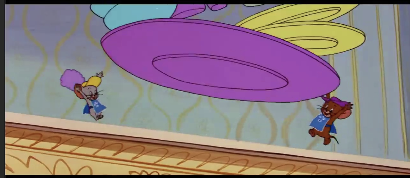

Predicted class: jerry
1/1 [==============================] - 0s 67ms/step


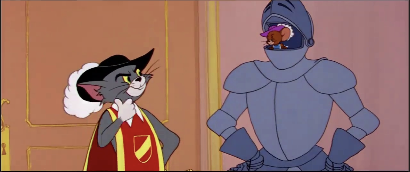

Predicted class: both
1/1 [==============================] - 0s 66ms/step


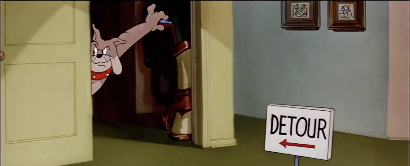

Predicted class: none


In [30]:
# Make the prediction
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
model = load_model('my_model.h5')  #load the model 
image_path1 = '/Users/shurui/demo.png' 
image_path2 = '/Users/shurui/demo2.png' 
image_path3 = '/Users/shurui/demo3.png' 
image_path4 = '/Users/shurui/demo4.png' 
#input your path(attention that the photo must be in rgb and lcd diplay,
#otherwise the array's value would be 0,so that there would have no prediction but none.)
img_array, predicted_class_name = predict_image_class(model, image_path1)  #prediction
img_array, predicted_class_name = predict_image_class(model, image_path2)  #prediction
img_array, predicted_class_name = predict_image_class(model, image_path3)  #prediction
img_array, predicted_class_name = predict_image_class(model, image_path4)  #prediction